In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import torchvision as tv
from IPython.display import display, clear_output
from tqdm import tqdm

# Noisy example
Take an image, and add some noise to it

## Difference operator
The difference operator is like a convolution by a particular kernel.

In [3]:
def difference_operator():
    pass

# Proximal operators
We can calculate the proximal operators for each of the terms of the sum separately, then use these separate computations in an algorithm such as forward-backward or ADMM.

In [4]:
def proximal_L2():
    pass

# Treating the finite difference operator

# Lagrangian formulation

We could treat the problem as minimizing

$$\frac{1}{2}\|Ax-b\|^2_2 + \|y\|_1$$
under the constraints $y = Dx$ and $x\in C$

# Deblurring the image

# Several algorithms for optimizing the loss function

### Adam

In [2]:
def open_image_bw(path, downsample=1):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor
    ])
    img = Image.open(path)
    original_width, original_height = img.size
    img = img.convert('L')
    img = img.resize((original_width // downsample, original_height // downsample))
    return transform(img)

In [3]:
gray_dog_tensor = open_image_bw('dog.jpg', downsample=10)

In [91]:
class FiniteDifference(nn.Module):
    def __init__(self):
        super().__init__()
        filter = torch.tensor([
            [-1, 1],
            [0, 0]
        ], dtype=torch.float32).reshape(1, 1, 2, 2)
        filter = filter / torch.norm(filter, p=2)
        self.filter = nn.Parameter(filter, requires_grad=False)
    
    def forward(self, image):
        return torch.nn.functional.conv2d(image, self.filter, padding = 1)

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size, sigma):
        super().__init__()
        self.gaussian_blur = tv.transforms.GaussianBlur(kernel_size, sigma)
    
    def forward(self, image):
        return self.gaussian_blur(image)
    
class ReconstructionLoss(nn.Module):
    def __init__(self, image, penalty_weight, gaussian_std, kernel_size):
        super().__init__()
        self.image = nn.Parameter(image, requires_grad=False)
        self.gaussian_blur = GaussianBlur(kernel_size=kernel_size, sigma=gaussian_std)
        self.finite_difference = FiniteDifference()
        reconstruction = image.clone().detach()
        self.reconstruction = nn.Parameter(reconstruction, requires_grad=True)
        self.penalty_weight = nn.Parameter(torch.tensor(penalty_weight), requires_grad=False)
    def forward(self):
        blurred_reconstruction = self.gaussian_blur(self.reconstruction)
        l2_loss = 1/2 * torch.norm(blurred_reconstruction - self.image, p=2)**2
        finite_difference_reconstruction = self.finite_difference(self.reconstruction)
        l1_loss = torch.norm(finite_difference_reconstruction, p=2)
        return l2_loss + self.penalty_weight*l1_loss

### Add noise

In [98]:
def add_noise(image, std_noise, gaussian_std=10, kernel_size=51, print_image=True):
    # Gaussian blur + noise
    # Show original
    printed_image = image.clone().detach()
    if print_image:
        print(f"original shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize((1500,900))
    if print_image:
        display(printed_image)
    noise = torch.randn(image.shape) * std_noise
    blurred_image = tv.transforms.functional.gaussian_blur(image, kernel_size=kernel_size, sigma=gaussian_std)
    noisy_image = blurred_image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    printed_image = noisy_image.clone().detach()
    if print_image:
        print(f"new shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize((1500,900))
    if print_image:
        display(printed_image)
    return noisy_image

original shape torch.Size([1, 211, 317])


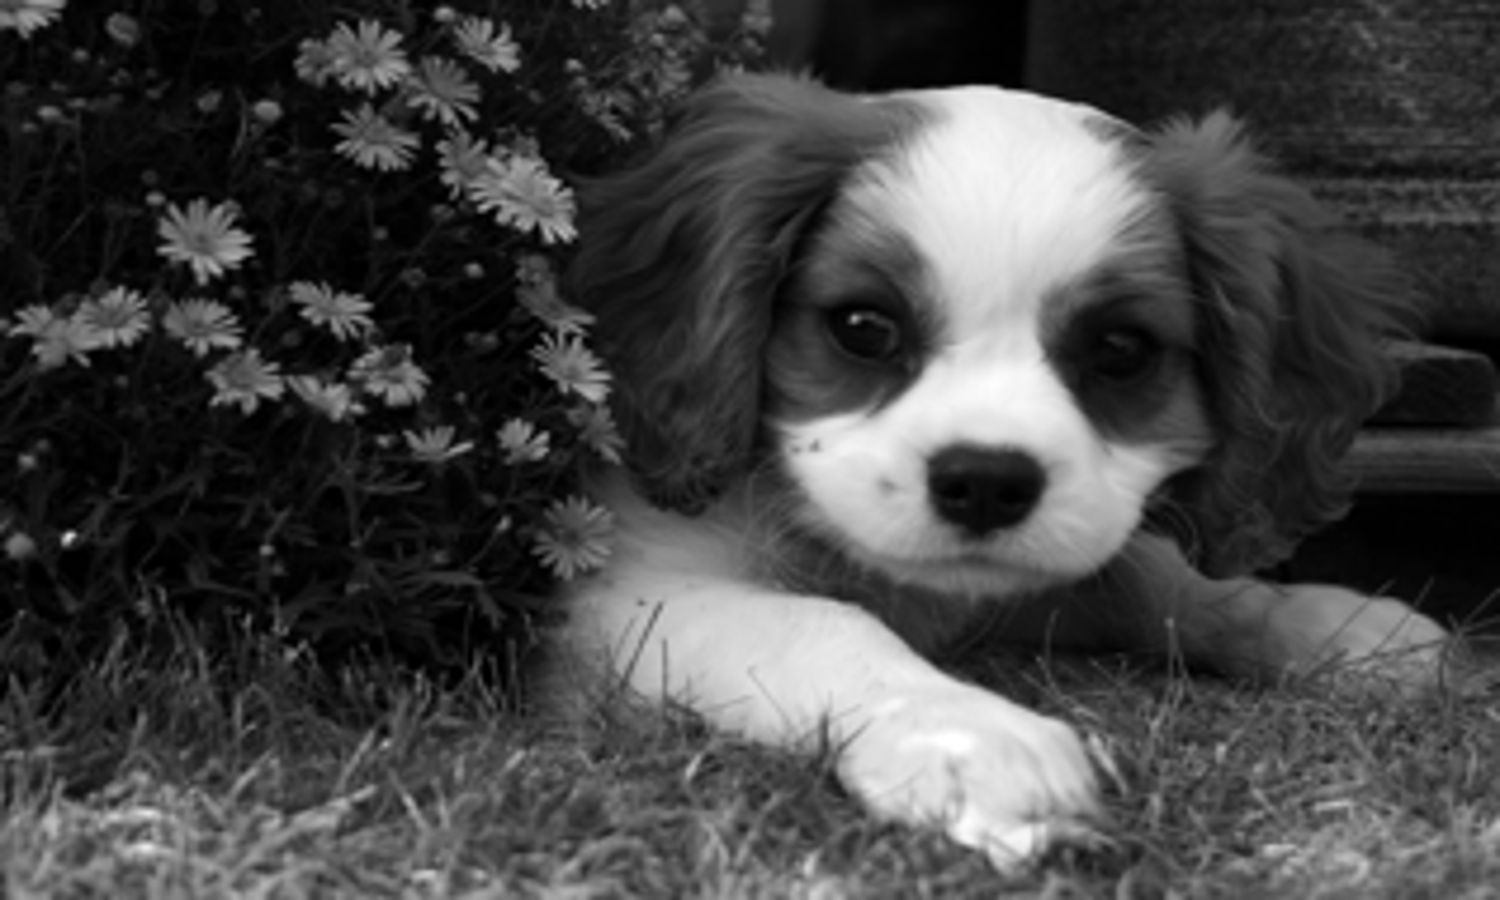

new shape torch.Size([1, 211, 317])


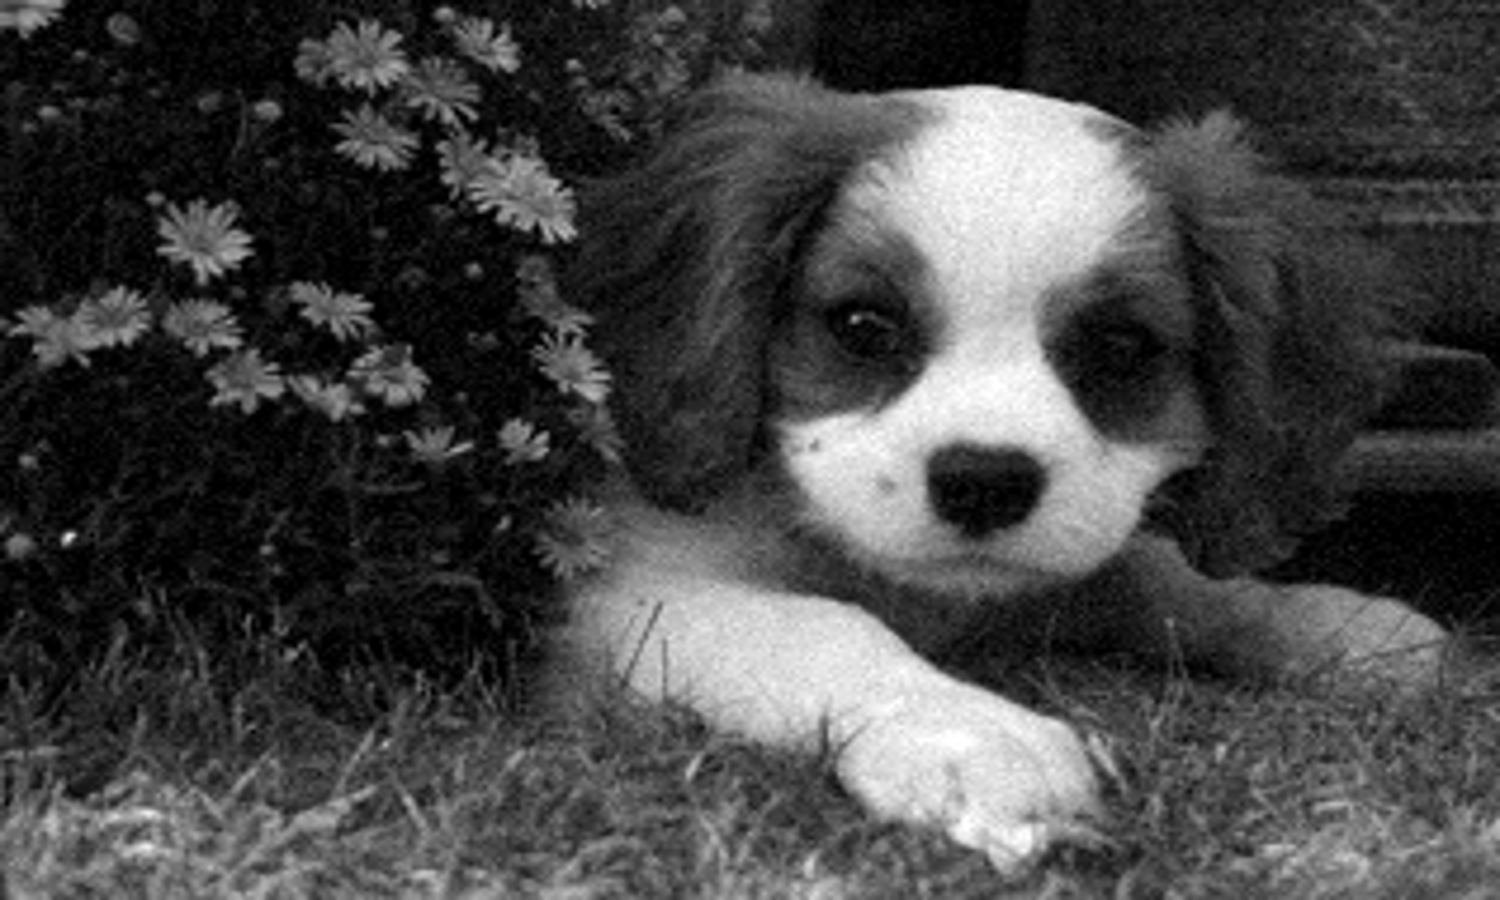

In [103]:
kernel_size = 3
gaussian_std = 0.001
std_noise = 0.03
noisy_image = add_noise(gray_dog_tensor, std_noise=std_noise, gaussian_std=gaussian_std, kernel_size=kernel_size, print_image=True)

Epoch 9000, Loss: 6.44590950012207


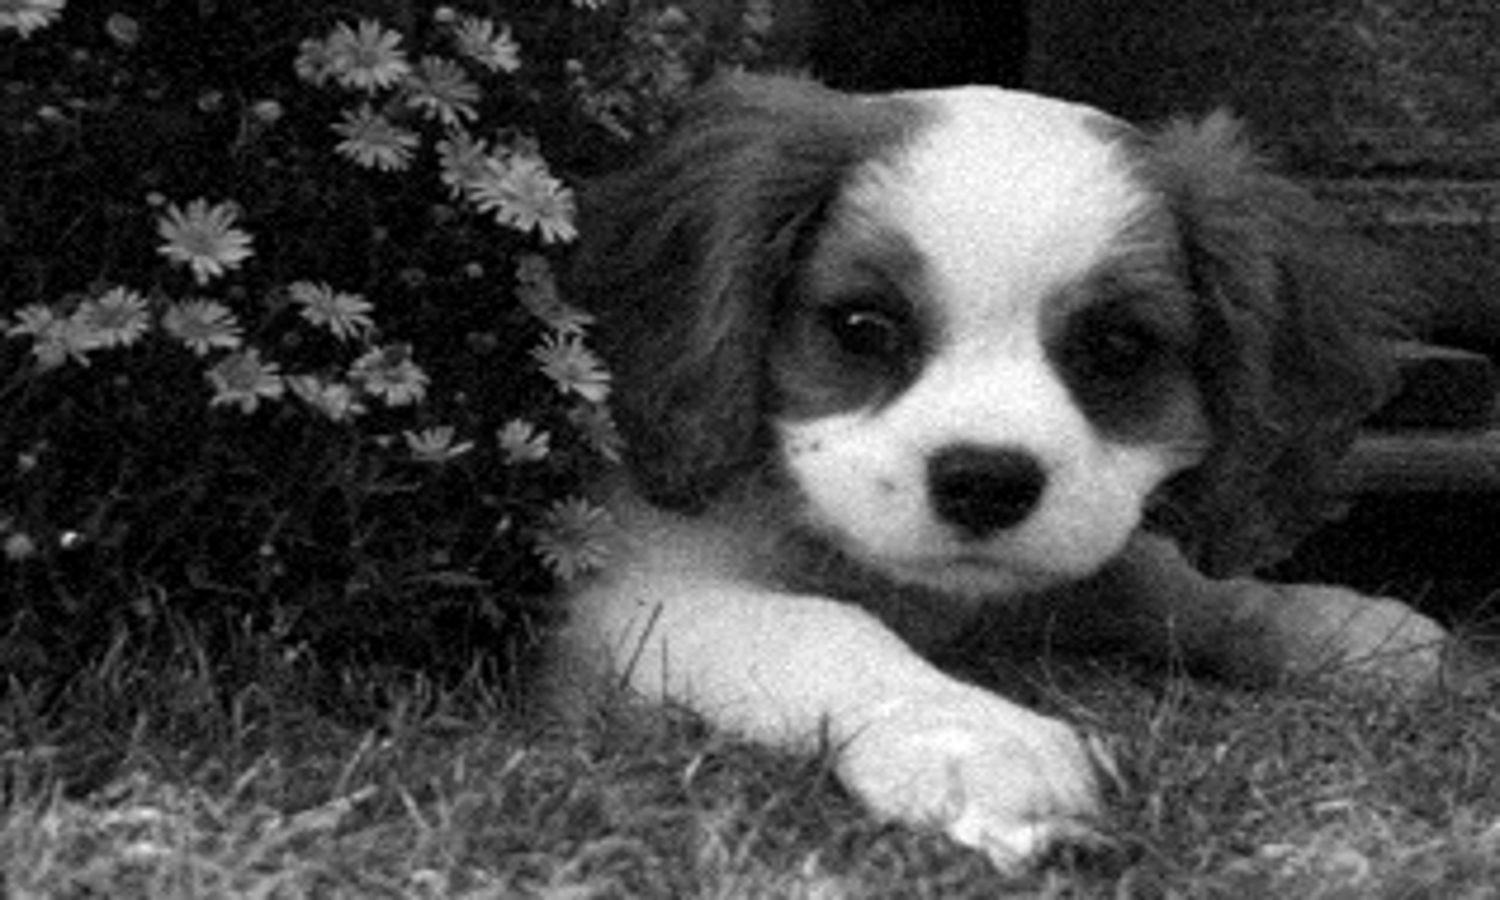

Loss: 6.445891380: 100%|██████████| 10000/10000 [00:06<00:00, 1513.79it/s]


In [105]:
kernel_size = 3
gaussian_std = 0.001
std_noise = 0.03
noisy_image = add_noise(gray_dog_tensor, std_noise=std_noise, gaussian_std=gaussian_std, kernel_size=kernel_size, print_image=False)
print(f"{kernel_size=}, {gaussian_std=}")
reconstruction_module = ReconstructionLoss(noisy_image, penalty_weight=0.5, gaussian_std=gaussian_std, kernel_size=kernel_size)
reconstruction_module.to('cuda')
# Now optimize the reconstruction module
optimizer = torch.optim.AdamW(reconstruction_module.parameters(), lr=0.01)
pbar = tqdm(range(10000))
for i in pbar:
    optimizer.zero_grad()
    loss = reconstruction_module()
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        pbar.set_description(f"Loss: {loss.item():.9f}")

    if i % 1000 == 0:
        # Clear the previous output
        clear_output(wait=True)
        print(f"Epoch {i}, Loss: {loss.item()}")
        
        # Clone the tensor, detach it from the computation graph, and move it to CPU
        result = reconstruction_module.reconstruction.clone().detach().cpu()
        # Convert to PIL image
        pil_image = transforms.ToPILImage()(result).resize((1500,900))
        # Display the image in the notebook
        display(pil_image)


In [41]:
result.min()

tensor(-0.0385)

# Checking the convergence speed for each of the algorithms

In [1]:
def accuracy_logger():
    # this function logs the value of the loss function, and the time taken by the iteration
    pass

In [ ]:
# Comparison of convergence. Do a loglog plot of the losses vs. iteration number, and vs. time.

# Testing the results